<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/Grid_Test_Knock_In_Call_1stock_Old_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(1.1, 1.6, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)

print(S_range)
print(K_range)
print(B_range)
print(sigma_range)
print(r_range)

[0.75       0.8055556  0.86111116 0.9166666  0.97222227 1.0277778
 1.0833334  1.138889   1.1944445  1.25      ]
[0.75       0.82142854 0.89285713 0.9642857  1.0357143  1.1071429
 1.1785713  1.25      ]
[1.1       1.1714286 1.2428572 1.3142858 1.3857143 1.4571428 1.5285715
 1.6      ]
[0.15       0.25       0.35000002 0.45      ]
[0.01  0.025 0.04 ]


In [3]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_out_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_out_index]/(knock_out_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

goptionvalueavg = jax.grad(optionvalueavg, argnums=1)

#################################################################### Adjust all parameters here (not inside class)
numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)
keys = jax.random.split(key, numpaths)

S_range = jnp.linspace(0.75, 1.25, 10)
K_range = jnp.linspace(0.75, 1.25, 8)
B_range = jnp.linspace(1.1, 1.6, 8)
sigma_range = jnp.linspace(0.15, 0.45, 4)
r_range = jnp.linspace(0.01, 0.04, 3)
T = 1.0

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
####################################################################

call = []
count = 0

for S in S_range:
  for K in K_range:
    for B in B_range:
      for r in r_range:
        for sigma in sigma_range:    

          initial_stocks = jnp.array([S]*numstocks) # must be float
          r_tmp = jnp.array([r]*numstocks)
          drift = r_tmp
          cov = jnp.identity(numstocks)*sigma*sigma

          Knock_In_Call_price = optionvalueavg(key, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths)
          Deltas = goptionvalueavg(keys, initial_stocks, numsteps, drift, r_tmp, cov, K, B, T,numpaths)
          call.append([T, K, B, S, sigma, r, r, Knock_In_Call_price] + list(Deltas)) #T, K, B, S, sigma, mu, r, price, delta
          
          count += 1
          print(count)

串流輸出內容已截斷至最後 5000 行。
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876

In [4]:
Thedataset = pd.DataFrame(call)
#T, K, B, S, sigma, r, r
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,1.1,0.75,0.15,0.010,0.010,0.003048922,0.012453
1,1.0,0.75,1.1,0.75,0.25,0.010,0.010,0.034801595,0.139740
2,1.0,0.75,1.1,0.75,0.35,0.010,0.010,0.07676853,0.303222
3,1.0,0.75,1.1,0.75,0.45,0.010,0.010,0.112610094,0.437808
4,1.0,0.75,1.1,0.75,0.15,0.025,0.025,0.0039772727,0.016244
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.6,1.25,0.45,0.025,0.025,0.1938404,0.627148
7676,1.0,1.25,1.6,1.25,0.15,0.040,0.040,0.043076728,0.150861
7677,1.0,1.25,1.6,1.25,0.25,0.040,0.040,0.113577545,0.386973
7678,1.0,1.25,1.6,1.25,0.35,0.040,0.040,0.163221,0.541586


In [5]:
# save to csv
Thedataset.to_csv('Knock_In_Call_1stock_MC_Datset_v2.csv', index=False, header=False)

In [6]:
# read csv
import pandas as pd
#T, K, B, S, sigma, r, r
Thedataset = pd.read_csv('Knock_In_Call_1stock_MC_Datset_v2.csv', header=None)
Thedataset

,0,1,2,3,4,5,6,7,8
0,1.0,0.75,1.1,0.75,0.15,0.010,0.010,0.003049,0.012453
1,1.0,0.75,1.1,0.75,0.25,0.010,0.010,0.034802,0.139740
2,1.0,0.75,1.1,0.75,0.35,0.010,0.010,0.076769,0.303222
3,1.0,0.75,1.1,0.75,0.45,0.010,0.010,0.112610,0.437808
4,1.0,0.75,1.1,0.75,0.15,0.025,0.025,0.003977,0.016244
...,...,...,...,...,...,...,...,...,...
7675,1.0,1.25,1.6,1.25,0.45,0.025,0.025,0.193840,0.627148
7676,1.0,1.25,1.6,1.25,0.15,0.040,0.040,0.043077,0.150861
7677,1.0,1.25,1.6,1.25,0.25,0.040,0.040,0.113578,0.386973
7678,1.0,1.25,1.6,1.25,0.35,0.040,0.040,0.163221,0.541586


# Construct Neural Net

In [11]:
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
import pandas as pd
from torch.utils.dlpack import from_dlpack
import torch
torch.set_printoptions(precision=6)

Thedataset_X = Thedataset.iloc[:,:7]
Thedataset_Y = Thedataset.iloc[:,7:]

class OptionDataSet(object):
    
    def __init__(self, max_len):
        self.num = 0
        self.max_length = max_len
        self.X = cupy.array(Thedataset_X)
        self.Y = cupy.array(Thedataset_Y)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration

        self.num += 1
        return (from_dlpack(self.X.toDlpack()), from_dlpack(self.Y.toDlpack()))

# print
ds = OptionDataSet(max_len = 1)
for i in ds:
    print(i[0])
    print(i[0].shape)
    print(i[1])
    print(i[1].shape)

tensor([[1.000000, 0.750000, 1.100000,  ..., 0.150000, 0.010000, 0.010000],
        [1.000000, 0.750000, 1.100000,  ..., 0.250000, 0.010000, 0.010000],
        [1.000000, 0.750000, 1.100000,  ..., 0.350000, 0.010000, 0.010000],
        ...,
        [1.000000, 1.250000, 1.600000,  ..., 0.250000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.600000,  ..., 0.350000, 0.040000, 0.040000],
        [1.000000, 1.250000, 1.600000,  ..., 0.450000, 0.040000, 0.040000]],
       device='cuda:0', dtype=torch.float64)
torch.Size([7680, 7])
tensor([[0.003049, 0.012453],
        [0.034802, 0.139740],
        [0.076769, 0.303222],
        ...,
        [0.113578, 0.386973],
        [0.163221, 0.541586],
        [0.198325, 0.641520]], device='cuda:0', dtype=torch.float64)
torch.Size([7680, 2])


In [7]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*1, 64) # remember to change this!
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 2) # 2 outputs: price, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 0.5, 0.5, 0.5, 0.3, 0.03, 0.03]*1)) # don't use numpy here - will give error later
                                                                               # T, K, B, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = (x - torch.tensor([0.0, 0.75, 0.6, 0.75, 0.15, 0.01, 0.01]*1).cuda()) / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [8]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 10.6 MB/s 


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 200) # Use max_len to adjust

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    # print(x)
    # print(x.shape)
    y = batch[1]
    # print(y)
    # print(y.shape)
    y_pred = model(x.float())
    # print(y_pred)
    # print(y_pred.shape)

    # def compute_deltas(x):
    #   inputs = x.float()
    #   inputs.requires_grad = True
    #   first_order_gradient = grad(model(inputs), inputs, create_graph=False)
    #   return first_order_gradient[0][[3]]  # Now index 3 is stock price, not 2

    # deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    # y_pred = torch.cat((y_pred, deltas), 1)
    # # print(y_pred)
    # # print(y_pred.shape)

    loss_weight = torch.tensor([1, 1]).cuda()
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 500)

model_save_name = 'jax_knock_in_1stock_oldmethod_2.pth'
path = F"/content/drive/MyDrive/AFP Project/Judy/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 0.05417862461669471 average time 0.008674967500019193 iter num 20
loss 0.04377463530780469 average time 0.006651952700053698 iter num 40
loss 0.030825851296868483 average time 0.00593986448340426 iter num 60
loss 0.01719129557785383 average time 0.00568013887508414 iter num 80
loss 0.009949399849751024 average time 0.005399171280050723 iter num 100
loss 0.0077896978196093395 average time 0.0052266598750444855 iter num 120
loss 0.007063613271647808 average time 0.005151454721473264 iter num 140
loss 0.006804895732908043 average time 0.005012163693783123 iter num 160
loss 0.006716953596563938 average time 0.004921335455583176 iter num 180
loss 0.006694024198462482 average time 0.004866574900011074 iter num 200
loss 0.006102396887437153 average time 0.004150497700084088 iter num 20
loss 0.0059446392828272875 average time 0.0040000360749672835 iter num 40
loss 0.005844531323832997 average time 0.004291859100006453 iter num 60
loss 0.005761267892834262 average time 0.004264558349984781

In [ ]:
# 

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_knock_out_1stock_densergrid_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
model_save_name = 'jax_knock_out_1stock_MC_oneDS_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=7, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
)


**Continue to train model**

#Results

In [14]:
import torch
inputs = torch.tensor([[1, 1, 1.3, 1, 0.25, 0.02, 0.02]]).cuda() # T, K, B, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

# price, delta
# should be around (0.080571815,0.32687128)

price: tensor([[0.080226, 0.326266]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [15]:
# Knock out call

# now change code such that 'numsteps' does not represent year
# make dt = year / numsteps
# Add r, and notice that noise must have mean 0, not drift, or else it'll give large option prices
# (done)
# after making the changes, the values are still correct

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # up-and-in call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_out_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    r_mean_array = jnp.tile(jnp.cumsum(r), (numpaths, 1))[jnp.arange(numpaths), knock_out_index]/(knock_out_index+1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

numstocks = 1
numsteps = 50
numpaths = 2000000

rng = jax.random.PRNGKey(1)
rng, key = jax.random.split(rng)

drift = jnp.array([0.02]*numstocks)
r = drift # let r = drift to match B-S

cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([1.]*numstocks) # must be float

T = 1.0
K = 1.0
B = 1.3 # if B is set to 0, equivalent to European call

fast_simple = jax.jit(Brownian_motion, static_argnums=2)

keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T,numpaths)) # here numsteps different from T

# delta
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T,numpaths)) # here numsteps different from T

0.080571815
[0.32687128]


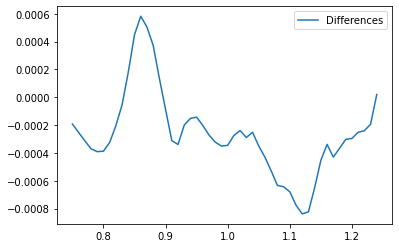

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def compute_price(S):
    inputs = torch.tensor([[1, 1, 1.3, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][0]

prices = np.arange(0.75, 1.25, 0.01)
model_call_prices = []
correct_call_prices = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_prices.append(compute_price(p).item())
    correct_call_prices.append(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T,numpaths))

#plt.plot(prices, model_call_prices, label = "model_call_prices")
#plt.plot(prices, correct_call_prices, label = "correct_call_prices")
plt.plot(prices, np.array(model_call_prices)-np.array(correct_call_prices), label = "Differences")
plt.legend()
plt.show()

# Delta

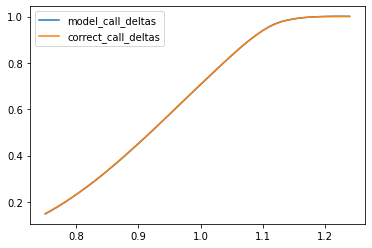

In [40]:
##Using gradient, Change only 1 S0 at a time
B = 1.1
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1, B, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.0, B, T,numpaths))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

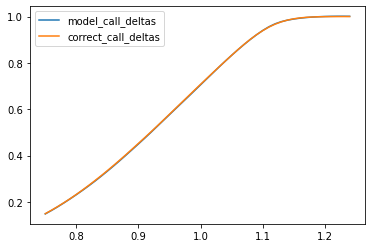

In [41]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 0.775, B, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 0.775, B, T,numpaths))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas, label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()

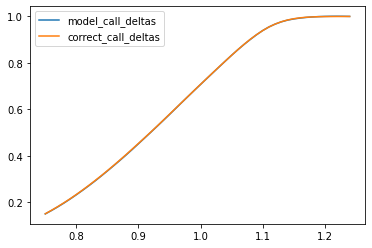

In [42]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np

def compute_delta(S):
    inputs = torch.tensor([[1, 1.225, B, S, 0.25, 0.02, 0.02]]).cuda()
    return model(inputs.float())[0][1]

prices = np.arange(0.75, 1.25, 0.01)
model_call_deltas = []
correct_call_deltas = []
for p in prices:
    initial_stocks = jnp.array([p]*numstocks) # must be float
    model_call_deltas.append(compute_delta(p).item())
    correct_call_deltas.append(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, 1.225, B, T,numpaths))

plt.plot(prices, model_call_deltas, label = "model_call_deltas")
plt.plot(prices, correct_call_deltas,   label = "correct_call_deltas")
#plt.plot(prices, np.array(model_call_deltas)-np.array(correct_call_deltas), label = "Differences")
plt.legend()
plt.show()